In [1]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/DiTing2.0/'

!pip install deepwave

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 82.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import deepwave
import matplotlib.pyplot as plt
from deepwave import scalar
import datetime
from tqdm import tqdm
import pickle
import numpy as np
# !pip install pyvista imageio


In [4]:
#@title Generate random velocity model 3d

class SeismicConfig:
    """Configuration class for seismic modeling"""
    def __init__(
        self,
        model_dims=(128, 128, 128),
        v0: float = 1500.0,  # Background velocity
        v_min: float = 1500.0,  # Minimum velocity
        v_max: float = 4500.0,  # Maximum velocity
        dv: float = 500.0,  # Velocity variation
    ):
        self.model_dims = model_dims
        self.v0 = v0
        self.v_min = v_min
        self.v_max = v_max
        self.dv = dv

def create_velocity_model(
    cfg: SeismicConfig,
    device: torch.device,
    seed: int = None):
    """
    Generates 3D velocity model with realistic geological features

    Features:
    - Horizon layers with natural undulations
    - Curved layers with varying thickness
    - Complex salt bodies

    Args:
        cfg: Configuration object containing model parameters
        device: Computation device (CPU/GPU)
        seed: Random seed for reproducibility (default: None)

    Returns:
        3D velocity tensor with shape (nx, ny, nz)
    """
    # Set random seed if provided
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    nx, ny, nz = cfg.model_dims

    # Initialize base velocity model
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Create coordinate grids
    X, Y, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(ny, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    # Generate horizon layers with undulations
    num_layers = torch.randint(4, 8, (1,)).item()
    for i in range(num_layers):
        # Layer depth function with undulations
        depth_base = (i + 1) * nz // (num_layers + 1)

        # Add undulations using combination of sine waves
        undulation = (
            10 * torch.sin(2 * np.pi * X[:,:,0] / nx * torch.rand(1, device=device)) +
            10 * torch.cos(2 * np.pi * Y[:,:,0] / ny * torch.rand(1, device=device)) +
            5 * torch.sin(4 * np.pi * (X[:,:,0] + Y[:,:,0]) / (nx + ny))
        )

        # Add curved component
        curve = 0.1 * ((X[:,:,0] - nx/2)**2 + (Y[:,:,0] - ny/2)**2) / (nx * ny)

        # Create layer depth map (2D)
        layer_depth = depth_base + undulation + curve

        # Create 3D layer mask
        base_vel = 2000 + i * 200 + torch.randn(1, device=device) * 100

        for i_x in range(nx):
            for i_y in range(ny):
                depth = int(layer_depth[i_x, i_y].item())
                if depth < nz:  # Ensure depth is within bounds
                    velocity[i_x, i_y, depth:] = base_vel

    # Add salt bodies with complex shapes
    num_salt = torch.randint(1, 3, (1,)).item()
    for _ in range(num_salt):
        # Salt body center and dimensions
        x0 = torch.randint(nx//4, 3*nx//4, (1,), device=device).item()
        y0 = torch.randint(ny//4, 3*ny//4, (1,), device=device).item()
        z0 = torch.randint(nz//3, 2*nz//3, (1,), device=device).item()

        rx = torch.randint(10, max(11, nx//5), (1,), device=device).item()
        ry = torch.randint(10, max(11, ny//5), (1,), device=device).item()
        rz = torch.randint(10, max(11, nz//5), (1,), device=device).item()

        # Create salt body with basic ellipsoidal shape
        salt_mask = ((X - x0)**2/rx**2 + (Y - y0)**2/ry**2 + (Z - z0)**2/rz**2) < 1.0

        # Set salt velocity (typically around 4500 m/s)
        velocity[salt_mask] = 4500 + torch.randn(1, device=device) * 100

    # Ensure velocity is within realistic bounds
    return torch.clamp(velocity, cfg.v_min, cfg.v_max)



# Create configuration
cfg = SeismicConfig(
    model_dims=(128,128,128),
    v0=1500.0,
    v_min=1500.0,
    v_max=4500.0,
    dv=500.0
)

# Generate velocity model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# velocity_model = create_velocity_model(cfg, device, 0) # [128,128,128]
# velocity_model = create_velocity_model(cfg, device, 0)[0] # [128,128]

In [5]:
#@title 二维地震记录-新
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available()
                      else 'cpu')
import torch
import deepwave
import deepwave
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter

def v2seimic_record(slice_v, patch_size=128, device='cuda', n_shots=5):  # Increased n_shots for CMP
    """
    Generate seismic record for a 2D velocity slice

    Args:
        slice_v: 2D velocity slice (128, 128)
        patch_size: size of square patches (default: 128)
        device: computation device (default: 'cuda')
        n_shots: number of shots to simulate (default: 5)

    Returns:
        receiver_amplitudes: Shot gathers
        source_locations: Source locations
        receiver_locations: Receiver locations
    """
    slice_v = slice_v.to(device)

    dx = 2.0
    n_sources_per_shot = 1
    n_receivers_per_shot = patch_size  # Full coverage
    freq = 25
    dt = 0.002
    nt = 300
    peak_time = 1.5 / freq
    source_depth = 2

    # Define source locations (evenly spaced across the model)
    source_locations = torch.zeros(n_shots, n_sources_per_shot, 2,
                                  dtype=torch.long, device=device)
    source_locations[..., 1] = source_depth  # Keep source depth fixed near surface

    # Distribute sources evenly across the model
    shot_positions = torch.linspace(10, patch_size-10, n_shots).long() # 小数出现会bug吗？
    for i in range(n_shots):
        source_locations[i, 0, 0] = shot_positions[i]

    # Receiver locations (along the surface)
    receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
    for i in range(n_shots):
        receiver_locations[i, :, 0] = torch.arange(patch_size)
        receiver_locations[i, :, 1] = 2

    # Source amplitudes
    source_amplitudes = deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, n_sources_per_shot, 1).to(device)

    # Forward modeling
    out = deepwave.scalar(slice_v, dx, dt,
                          source_amplitudes=source_amplitudes,
                          source_locations=source_locations,
                          receiver_locations=receiver_locations,
                          accuracy=8,
                          pml_freq=freq)

    receiver_amplitudes = out[-1]

    return receiver_amplitudes, source_locations, receiver_locations

def apply_bandpass_filter(shot_gathers, dt=0.002, lowcut=5, highcut=50):
    """
    Apply bandpass filter to shot gathers

    Args:
        shot_gathers: Shot gathers tensor [n_shots, n_receivers, nt]
        dt: Time sampling interval (default: 0.002)
        lowcut: Low cutoff frequency in Hz (default: 5)
        highcut: High cutoff frequency in Hz (default: 50)

    Returns:
        filtered_gathers: Filtered shot gathers
    """
    # Convert to numpy for scipy processing
    shot_gathers_np = shot_gathers.cpu().numpy()
    n_shots, n_receivers, nt = shot_gathers_np.shape

    # Design Butterworth bandpass filter
    nyquist = 0.5 / dt
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')

    # Apply filter to each trace
    filtered_gathers = np.zeros_like(shot_gathers_np)
    for i in range(n_shots):
        for j in range(n_receivers):
            filtered_gathers[i, j, :] = signal.filtfilt(b, a, shot_gathers_np[i, j, :])

    # Optional: Apply gain compensation (t^2 scaling)
    t = np.arange(nt) * dt
    t_gain = np.sqrt(t + 0.001)  # Add small value to avoid division by zero
    for i in range(n_shots):
        for j in range(n_receivers):
            filtered_gathers[i, j, :] *= t_gain

    return torch.tensor(filtered_gathers, device=shot_gathers.device)

def perform_cmp_sorting(shot_gathers, source_locations, receiver_locations):
    """
    Perform CMP (Common Mid Point) sorting on shot gathers

    Args:
        shot_gathers: Shot gathers tensor [n_shots, n_receivers, nt]
        source_locations: Source locations [n_shots, n_sources_per_shot, 2]
        receiver_locations: Receiver locations [n_shots, n_receivers, 2]

    Returns:
        cmp_gathers: CMP sorted gathers
        cmp_locations: CMP locations
        fold_count: Fold count for each CMP
    """
    # Convert to numpy for processing
    shot_gathers_np = shot_gathers.cpu().numpy()
    source_locs_np = source_locations.cpu().numpy()
    receiver_locs_np = receiver_locations.cpu().numpy()

    n_shots, n_receivers, nt = shot_gathers_np.shape

    # Calculate midpoints for each source-receiver pair
    midpoints = np.zeros((n_shots, n_receivers))
    for i in range(n_shots):
        src_x = source_locs_np[i, 0, 0]
        for j in range(n_receivers):
            rec_x = receiver_locs_np[i, j, 0]
            midpoints[i, j] = (src_x + rec_x) / 2

    # Calculate offsets for each source-receiver pair
    offsets = np.zeros((n_shots, n_receivers))
    for i in range(n_shots):
        src_x = source_locs_np[i, 0, 0]
        for j in range(n_receivers):
            rec_x = receiver_locs_np[i, j, 0]
            offsets[i, j] = abs(rec_x - src_x)

    # Find unique midpoints
    unique_midpoints = np.unique(midpoints.flatten())
    unique_midpoints.sort()
    n_cmps = len(unique_midpoints)

    # Calculate maximum fold
    max_fold = min(n_shots, n_receivers)

    # Initialize CMP gathers
    cmp_gathers = np.zeros((n_cmps, max_fold, nt)) # (共反射点，叠加数，nt)
    cmp_offsets = np.zeros((n_cmps, max_fold))
    fold_count = np.zeros(n_cmps, dtype=int)

    # Sort traces into CMP gathers
    for i in range(n_shots):             # 遍历所有震源
        for j in range(n_receivers):     # 遍历所有检波器
            midpoint = midpoints[i, j]   # 获取当前震源和检波器对的共中心点
            cmp_idx = np.where(unique_midpoints == midpoint)[0][0]  # 找到共中心点在唯一列表中的索引

            if fold_count[cmp_idx] < max_fold:  # 检查当前 CMP 道集的叠加次数是否小于最大叠加次数
                cmp_gathers[cmp_idx, fold_count[cmp_idx], :] = shot_gathers_np[i, j, :]  # 将地震道加入 CMP 道集
                cmp_offsets[cmp_idx, fold_count[cmp_idx]] = offsets[i, j]  # 记录炮检距
                fold_count[cmp_idx] += 1  # 增加当前 CMP 道集的叠加次数

    return cmp_gathers, unique_midpoints, cmp_offsets, fold_count

def plot_shot_gathers(shot_gathers, title="Shot Gathers"):
    """
    Plot shot gathers

    Args:
        shot_gathers: Shot gathers tensor [n_shots, n_receivers, nt]
        title: Plot title
    """
    n_shots = shot_gathers.shape[0]
    fig, axes = plt.subplots(1, n_shots, figsize=(n_shots*4, 6))

    if n_shots == 1:
        axes = [axes]

    for i in range(n_shots):
        im = axes[i].imshow(shot_gathers[i].cpu().numpy(), aspect='auto', cmap='seismic',
                          vmin=-0.01, vmax=0.01)
        axes[i].set_title(f"Shot {i+1}")
        axes[i].set_xlabel("Receiver")
        axes[i].set_ylabel("Time")

    plt.colorbar(im, ax=axes, label="Amplitude")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_cmp_gathers(cmp_gathers, fold_count, cmp_locations, n_cmps_to_show=5):
    """
    Plot CMP gathers

    Args:
        cmp_gathers: CMP gathers [n_cmps, max_fold, nt]
        fold_count: Fold count for each CMP
        cmp_locations: CMP locations
        n_cmps_to_show: Number of CMPs to show
    """
    # Select CMPs with highest fold
    indices = np.argsort(fold_count)[-n_cmps_to_show:]

    fig, axes = plt.subplots(1, n_cmps_to_show, figsize=(n_cmps_to_show*4, 6))

    if n_cmps_to_show == 1:
        axes = [axes]

    for i, idx in enumerate(indices):
        # Only plot up to the actual fold
        actual_fold = fold_count[idx]
        data_to_plot = cmp_gathers[idx, :actual_fold, :]

        im = axes[i].imshow(data_to_plot, aspect='auto', cmap='seismic',
                          vmin=-0.01, vmax=0.01)
        axes[i].set_title(f"CMP at x={cmp_locations[idx]:.1f}\nFold={actual_fold}")
        axes[i].set_xlabel("Trace")
        axes[i].set_ylabel("Time")

    plt.colorbar(im, ax=axes, label="Amplitude")
    plt.suptitle("CMP Gathers")
    plt.tight_layout()
    plt.show()

# Example usage
def process_seismic_data(velocity_model, patch_size=128, n_shots=5):
    """
    Process seismic data: generate shot gathers, apply bandpass filter, and perform CMP sorting

    Args:
        velocity_model: 2D velocity model tensor
        patch_size: Size of square patches
        n_shots: Number of shots
    """
    # Generate shot gathers
    shot_gathers, source_locs, receiver_locs = v2seimic_record(
        velocity_model, patch_size=patch_size, n_shots=n_shots
    )

    # Plot original shot gathers
    plot_shot_gathers(shot_gathers, "Original Shot Gathers")

    # Apply bandpass filter
    filtered_gathers = apply_bandpass_filter(shot_gathers, lowcut=5, highcut=50)

    # Plot filtered shot gathers
    plot_shot_gathers(filtered_gathers, "Filtered Shot Gathers")

    # Perform CMP sorting
    cmp_gathers, cmp_locations, cmp_offsets, fold_count = perform_cmp_sorting(
        filtered_gathers, source_locs, receiver_locs
    )

    # Plot CMP gathers
    plot_cmp_gathers(cmp_gathers, fold_count, cmp_locations, n_cmps_to_show=5)

    return {
        'shot_gathers': shot_gathers,
        'filtered_gathers': filtered_gathers,
        'cmp_gathers': cmp_gathers,
        'cmp_locations': cmp_locations,
        'cmp_offsets': cmp_offsets,
        'fold_count': fold_count
    }

process_seismic_data(velocity_model)

/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.11/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
#@title 二维地震记录-老
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available()
                      else 'cpu')
import torch
import deepwave

def v2seimic_record(slice_v, patch_size=128, device='cuda'):
    """
    Generate seismic record for a 2D velocity slice

    Args:
        slice_v: 2D velocity slice (128, 128)
        patch_size: size of square patches (default: 128)
        device: computation device (default: 'cuda')
    """
    slice_v = slice_v.to(device)

    dx = 2.0
    n_shots = 1
    n_sources_per_shot = 1
    n_receivers_per_shot = 300
    freq = 25
    dt = 0.002
    nt = 300
    peak_time = 1.5 / freq
    source_depth = 2

    # Source location (middle of the slice)
    source_locations = torch.zeros(n_shots, n_sources_per_shot, 2,
                                  dtype=torch.long, device=device)
    source_locations[..., 1] = source_depth  # Keep source depth fixed near surface
    source_locations[:, 0, 0] = torch.clamp(    # torch.arange(0, n_shots) * d_source + first_source,
        torch.arange(1,2)*(patch_size/2), #mid point source
        0, patch_size-1
    )

    # Receiver locations (along the surface)
    receiver_locations = torch.zeros(1, n_receivers_per_shot, 2, dtype=torch.long, device=device)
    receiver_locations[0, :, 0] = torch.arange(patch_size)
    receiver_locations[0, :, 1] = 2

    # Source amplitudes
    source_amplitudes = deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, n_sources_per_shot, 1).to(device)
    # Forward modeling
    out = deepwave.scalar(slice_v, dx, dt,
                          source_amplitudes=source_amplitudes,
                          source_locations=source_locations,
                          receiver_locations=receiver_locations,
                          accuracy=8,
                          pml_freq=freq)

    receiver_amplitudes = out[-1]

    return receiver_amplitudes

def generate_3d_seismic_records(v, dim=128, device='cuda'):
    """
    Generate seismic records for a 3D velocity model

    Args:
        v: 3D velocity model (128, 128, 128)
        device: computation device (default: 'cuda')

    Returns:
        torch.Tensor: Seismic records (128, 128, 128, 2)
    """
    # get seismic record shape
    togetshape = v2seimic_record(v[...,0], 300, device=device) # ([1, 128, 300])
    _, H, W = togetshape.shape
    seismic_records_x = []
    seismic_records_y = []


    for i in range(dim):
        # Process XY plane
        yz_slice = v[i, :, :]
        seismic_record_x = v2seimic_record(yz_slice, 300, device=device).squeeze()
        seismic_records_x.append(seismic_record_x)
    for i in range(dim):
        # Process XZ plane
        xz_slice = v[:, i, :]
        seismic_record_y = v2seimic_record(xz_slice, 300, device=device).squeeze()
        seismic_records_y.append(seismic_record_y)
    x_stack = torch.stack(seismic_records_x)
    y_stack = torch.stack(seismic_records_y)

    seismic_records = torch.stack([x_stack, y_stack], dim=-1)
    return seismic_records

# Main execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
v = create_velocity_model(cfg,device)  # [300,300,300]
seismic_records = generate_3d_seismic_records(v,  300, device).permute(1,2,0,3) # [H,nt,dim,X/Y value]

print(f"Seismic records shape: {seismic_records.shape}")

Seismic records shape: torch.Size([300, 300, 300, 2])


In [ ]:
#@title generate random time-shifting velocity model 4d 18mins/10batches
class SeismicConfig:
    """Configuration class for seismic modeling with time-lapse capability"""
    def __init__(
        self,
        model_dims=(128, 128, 128),
        v0: float = 1500.0,  # Background velocity
        v_min: float = 1500.0,  # Minimum velocity
        v_max: float = 4500.0,  # Maximum velocity
        dv: float = 500.0,  # Velocity variation
        time_steps: list = None,  # Time steps for time-lapse simulation
        movement_rate: float = 0.1,  # Rate of geological feature movement
        deformation_rate: float = 0.05,  # Rate of geological feature deformation
    ):
        self.model_dims = model_dims
        self.v0 = v0
        self.v_min = v_min
        self.v_max = v_max
        self.dv = dv
        self.time_steps = time_steps if time_steps is not None else [0.0]
        self.movement_rate = movement_rate
        self.deformation_rate = deformation_rate

def create_time_lapse_velocity_models(
    cfg: SeismicConfig,
    device: torch.device,
    seed: int = None):
    """
    Generates 4D velocity models with realistic geological features evolving over time

    Features:
    - Horizon layers with natural undulations that migrate over time
    - Curved layers with varying thickness that deform over time
    - Complex salt bodies that slowly move and change shape

    Args:
        cfg: Configuration object containing model parameters
        device: Computation device (CPU/GPU)
        seed: Random seed for reproducibility (default: None)

    Returns:
        4D velocity tensor with shape (nt, nx, ny, nz) where nt is the number of time steps
    """
    # Set random seed if provided
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    nx, ny, nz = cfg.model_dims
    nt = len(cfg.time_steps)

    # Initialize 4D velocity tensor (time, x, y, z)
    velocity_4d = torch.zeros((nt, nx, ny, nz), device=device)

    # Create coordinate grids
    X, Y, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(ny, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    # Generate initial parameters for layers
    num_layers = torch.randint(4, 8, (1,)).item()
    layer_depths = [(i + 1) * nz // (num_layers + 1) for i in range(num_layers)]

    # Parameters for undulations
    freq_x = torch.rand((num_layers,), device=device) * 2
    freq_y = torch.rand((num_layers,), device=device) * 2
    phase_x = torch.rand((num_layers,), device=device) * 2 * np.pi
    phase_y = torch.rand((num_layers,), device=device) * 2 * np.pi
    amp_x = torch.rand((num_layers,), device=device) * 10 + 5
    amp_y = torch.rand((num_layers,), device=device) * 10 + 5

    # Parameters for salt bodies
    num_salt = torch.randint(1, 3, (1,)).item()
    salt_centers = []
    salt_radii = []
    salt_velocities = []
    salt_movement_dirs = []

    for _ in range(num_salt):
        # Salt body center and dimensions
        x0 = torch.randint(nx//4, 3*nx//4, (1,), device=device).item()
        y0 = torch.randint(ny//4, 3*ny//4, (1,), device=device).item()
        z0 = torch.randint(nz//3, 2*nz//3, (1,), device=device).item()

        rx = torch.randint(10, max(11, nx//5), (1,), device=device).item()
        ry = torch.randint(10, max(11, ny//5), (1,), device=device).item()
        rz = torch.randint(10, max(11, nz//5), (1,), device=device).item()

        # Movement direction for salt body
        dx = torch.randn(1, device=device).item()
        dy = torch.randn(1, device=device).item()
        dz = torch.randn(1, device=device).item() * 0.5  # Less movement in z direction

        # Normalize direction vector
        norm = (dx**2 + dy**2 + dz**2)**0.5
        dx, dy, dz = dx/norm, dy/norm, dz/norm

        salt_centers.append((x0, y0, z0))
        salt_radii.append((rx, ry, rz))
        salt_velocities.append(4500 + torch.randn(1, device=device).item() * 100)
        salt_movement_dirs.append((dx, dy, dz))

    # Generate velocity model for each time step
    for t_idx, t in enumerate(cfg.time_steps):
        # Initialize base velocity model for this time step
        velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

        # Generate horizon layers with undulations that evolve over time
        for i in range(num_layers):
            # Layer depth function with undulations that change over time
            depth_base = layer_depths[i]

            # Time-dependent phase shift
            time_phase_x = phase_x[i] + t * cfg.movement_rate * 2 * np.pi
            time_phase_y = phase_y[i] + t * cfg.movement_rate * 2 * np.pi

            # Time-dependent amplitude (subtle changes)
            time_amp_x = amp_x[i] * (1 + t * cfg.deformation_rate * torch.sin(torch.tensor(t * np.pi)))
            time_amp_y = amp_y[i] * (1 + t * cfg.deformation_rate * torch.cos(torch.tensor(t * np.pi)))

            # Add undulations using combination of sine waves with time-dependent parameters
            undulation = (
                time_amp_x * torch.sin(freq_x[i] * 2 * np.pi * X[:,:,0] / nx + time_phase_x) +
                time_amp_y * torch.cos(freq_y[i] * 2 * np.pi * Y[:,:,0] / ny + time_phase_y) +
                5 * torch.sin(4 * np.pi * (X[:,:,0] + Y[:,:,0]) / (nx + ny) + t * np.pi/2)
            )

            # Add curved component with time-dependent curvature
            curve_factor = 0.1 * (1 + 0.2 * torch.sin(torch.tensor(t * np.pi)))
            curve = curve_factor * ((X[:,:,0] - nx/2)**2 + (Y[:,:,0] - ny/2)**2) / (nx * ny)

            # Create layer depth map (2D) with time-dependent components
            layer_depth = depth_base + undulation + curve

            # Create 3D layer mask
            base_vel = 2000 + i * 200 + torch.randn(1, device=device) * 100

            for i_x in range(nx):
                for i_y in range(ny):
                    depth = int(layer_depth[i_x, i_y].item())
                    if depth < nz:  # Ensure depth is within bounds
                        velocity[i_x, i_y, depth:] = base_vel

        # Add salt bodies with complex shapes that move and deform over time
        for s in range(num_salt):
            # Get initial parameters
            x0, y0, z0 = salt_centers[s]
            rx, ry, rz = salt_radii[s]
            dx, dy, dz = salt_movement_dirs[s]

            # Time-dependent movement of salt body center
            x_t = x0 + t * cfg.movement_rate * nx * dx
            y_t = y0 + t * cfg.movement_rate * ny * dy
            z_t = z0 + t * cfg.movement_rate * nz * dz

            # Time-dependent deformation of salt body shape
            rx_t = rx * (1 + cfg.deformation_rate * t * torch.sin(torch.tensor(t * np.pi)))
            ry_t = ry * (1 + cfg.deformation_rate * t * torch.cos(torch.tensor(t * np.pi)))
            rz_t = rz * (1 + cfg.deformation_rate * t * torch.sin(torch.tensor(t * np.pi + np.pi/3)))

            # Create salt body with time-evolving ellipsoidal shape
            salt_mask = ((X - x_t)**2/rx_t**2 + (Y - y_t)**2/ry_t**2 + (Z - z_t)**2/rz_t**2) < 1.0

            # Add some complexity to the salt body shape over time
            if t > 0:
                # Add time-dependent perturbation to salt body shape
                perturbation = torch.sin(X/10 + t) * torch.cos(Y/10 + 2*t) * torch.sin(Z/10 + 3*t)
                perturbation = perturbation * 0.2 * t  # Scale perturbation with time
                salt_mask = salt_mask | (((X - x_t)**2/rx_t**2 + (Y - y_t)**2/ry_t**2 + (Z - z_t)**2/rz_t**2 + perturbation) < 1.05)

            # Set salt velocity (typically around 4500 m/s)
            velocity[salt_mask] = salt_velocities[s]

        # Ensure velocity is within realistic bounds
        velocity_4d[t_idx] = torch.clamp(velocity, cfg.v_min, cfg.v_max)

    return velocity_4d


def generate_time_lapse_seismic_data(time_steps, seed=42):
    # Create configuration with time steps
    cfg = SeismicConfig(
        model_dims=(300, 300, 300),
        v0=1500.0,
        v_min=1500.0,
        v_max=4500.0,
        dv=500.0,
        time_steps=time_steps,
        movement_rate=0.05,  # Controls how fast features move
        deformation_rate=0.03  # Controls how fast features deform
    )

    # Generate velocity models
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    velocity_4d = create_time_lapse_velocity_models(cfg, device, seed=seed)

    return velocity_4d

# 批量生成速度模型
def generate_batch_time_lapse_data(batch_size, time_steps):
    """
    批量生成时序三维速度模型数据，并使用TQDM显示进度

    Args:
        batch_size: 批大小
        time_steps: 时间步长列表

    Returns:
        torch.Tensor: 形状为 [batch_size, len(time_steps), 300, 300, 300] 的批量速度模型数据
    """
    batch_models = []

    # 使用tqdm创建进度条
    for b in tqdm(range(batch_size), desc="Generating batches", unit="batch"):
        # 为每个批次生成略有不同的时序数据
        models = generate_time_lapse_seismic_data(time_steps)
        batch_models.append(models)

    # 将所有批次的数据堆叠起来
    return torch.stack(batch_models)

# 示例使用
time_steps = [0.0, 0.25, 0.5, 0.75, 1.0]
batch_size = 10  # 设置批大小

# 生成批量数据
batch_velocity_models = generate_batch_time_lapse_data(batch_size, time_steps)
print(f"Generated batch of time-lapse velocity models with shape: {batch_velocity_models.shape}")

# 访问第一个批次的数据
first_batch = batch_velocity_models[0]
print(f"First batch shape: {first_batch.shape}")

# 访问第一个批次的第一个时间步的数据
first_time_step = first_batch[0]
print(f"First time step shape: {first_time_step.shape}")

# 查看一些统计信息
print(f"Min velocity: {batch_velocity_models.min().item():.2f} m/s")
print(f"Max velocity: {batch_velocity_models.max().item():.2f} m/s")
print(f"Mean velocity: {batch_velocity_models.mean().item():.2f} m/s")

torch.save(batch_velocity_models.permute(0,2,3,4,1), f_path+'batch_velocity_models.pt')


Generating batches: 100%|██████████| 10/10 [16:41<00:00, 100.16s/batch]


Generated batch of time-lapse velocity models with shape: torch.Size([10, 5, 300, 300, 300])
First batch shape: torch.Size([5, 300, 300, 300])
First time step shape: torch.Size([300, 300, 300])
Min velocity: 1500.00 m/s
Max velocity: 4500.00 m/s
Mean velocity: 2356.51 m/s


In [ ]:
batch_velocity_models = torch.load(f_path+'batch_velocity_models.pt')

<ipython-input-4-db352f8501e7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_velocity_models = torch.load(f_path+'batch_velocity_models.pt')


In [ ]:
# @title Default title text
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider, IntSlider, Layout
from IPython.display import display
import plotly.express as px

import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider, IntSlider, Layout, Dropdown
from IPython.display import display
import plotly.express as px

def visualize_3d_data(data_3d):
    """
    交互式可视化3D数据体

    参数:
        data_3d: 形状为(300, 300, 300)的numpy数组
    """
    # 检查输入数据维度
    print(f"数据维度: {data_3d.shape}")

    # 获取数据范围
    min_val = float(data_3d.min())
    max_val = float(data_3d.max())
    print(f"数据范围: [{min_val:.4f}, {max_val:.4f}]")

    # 创建切片可视化函数
    def view_slices(axis=0, slice_idx=150, opacity=0.7, colorscale='Viridis',
                    show_isosurface=False, iso_min=None, iso_max=None, iso_opacity=0.3):
        """显示3D数据的切片和可选的等值面"""

        # 处理None值
        if iso_min is None:
            iso_min = min_val + (max_val - min_val) * 0.3
        if iso_max is None:
            iso_max = min_val + (max_val - min_val) * 0.7

        fig = go.Figure()

        # 根据选择的轴提取切片
        if axis == 0:
            slice_data = data_3d[slice_idx, :, :]
            title = f"X轴切片 (x={slice_idx})"
        elif axis == 1:
            slice_data = data_3d[:, slice_idx, :]
            title = f"Y轴切片 (y={slice_idx})"
        else:
            slice_data = data_3d[:, :, slice_idx]
            title = f"Z轴切片 (z={slice_idx})"

        # 添加热图切片
        heatmap = go.Heatmap(
            z=slice_data,
            colorscale=colorscale,
            opacity=opacity
        )
        fig.add_trace(heatmap)

        # 设置图表布局
        fig.update_layout(
            title=title,
            width=600,
            height=600,
            margin=dict(l=20, r=20, t=40, b=20)
        )

        # 显示图表
        display(fig)

        # 如果需要，显示3D等值面
        if show_isosurface:
            # 为了提高性能，可以降采样数据
            downsample_factor = 2  # 每个维度上每2个点取1个
            downsampled = data_3d[::downsample_factor, ::downsample_factor, ::downsample_factor]

            fig3d = go.Figure(data=go.Volume(
                x=np.arange(0, data_3d.shape[0], downsample_factor),
                y=np.arange(0, data_3d.shape[1], downsample_factor),
                z=np.arange(0, data_3d.shape[2], downsample_factor),
                value=downsampled.flatten(),
                isomin=iso_min,
                isomax=iso_max,
                opacity=iso_opacity,
                surface_count=2,
                colorscale=colorscale
            ))

            fig3d.update_layout(
                title='3D等值面可视化',
                width=700,
                height=700,
                scene=dict(
                    xaxis=dict(title='X轴'),
                    yaxis=dict(title='Y轴'),
                    zaxis=dict(title='Z轴')
                ),
                margin=dict(l=0, r=0, t=40, b=0)
            )

            display(fig3d)

    # 创建体积渲染函数
    def volume_render(opacity=0.1, surface_count=10, colorscale='Viridis', downsample_factor=3):
        """创建3D体积渲染"""

        # 降采样数据以提高性能
        downsampled = data_3d[::downsample_factor, ::downsample_factor, ::downsample_factor]

        fig = go.Figure(data=go.Volume(
            x=np.arange(0, data_3d.shape[0], downsample_factor),
            y=np.arange(0, data_3d.shape[1], downsample_factor),
            z=np.arange(0, data_3d.shape[2], downsample_factor),
            value=downsampled.flatten(),
            opacity=opacity,
            surface_count=surface_count,
            colorscale=colorscale
        ))

        fig.update_layout(
            title='3D体积渲染',
            width=800,
            height=800,
            scene=dict(
                xaxis=dict(title='X轴'),
                yaxis=dict(title='Y轴'),
                zaxis=dict(title='Z轴')
            ),
            margin=dict(l=0, r=0, t=40, b=0)
        )

        display(fig)

    # 可用的颜色方案列表
    colorscales = ['Viridis', 'Plasma', 'Inferno', 'Magma', 'Cividis', 'Turbo',
                  'Blues', 'Greens', 'Reds', 'YlOrRd', 'RdBu', 'Jet']

    # # 创建交互式控件 - 2D切片可视化
    # print("2D切片可视化:")
    # interact(
    #     view_slices,
    #     axis=IntSlider(min=0, max=2, step=1, value=0, description='切片轴:'),
    #     slice_idx=IntSlider(min=0, max=min(data_3d.shape)-1, step=1, value=min(data_3d.shape)//2, description='切片位置:'),
    #     opacity=FloatSlider(min=0.1, max=1.0, step=0.1, value=0.7, description='透明度:'),
    #     colorscale=Dropdown(options=colorscales, value='Viridis', description='颜色方案:'),
    #     show_isosurface=False,
    #     iso_min=min_val + (max_val - min_val) * 0.3,  # 提供默认值而不是None
    #     iso_max=min_val + (max_val - min_val) * 0.7,  # 提供默认值而不是None
    #     iso_opacity=0.3
    # )

    # # 创建交互式控件 - 3D等值面可视化
    # print("\n3D等值面可视化:")
    # interact(
    #     view_slices,
    #     axis=IntSlider(min=0, max=2, step=1, value=0, description='切片轴:'),
    #     slice_idx=IntSlider(min=0, max=min(data_3d.shape)-1, step=1, value=min(data_3d.shape)//2, description='切片位置:'),
    #     opacity=FloatSlider(min=0.1, max=1.0, step=0.1, value=0.7, description='透明度:'),
    #     colorscale=Dropdown(options=colorscales, value='Viridis', description='颜色方案:'),
    #     show_isosurface=True,
    #     iso_min=FloatSlider(min=min_val, max=max_val, step=(max_val-min_val)/100,
    #                        value=min_val+(max_val-min_val)*0.3, description='等值面最小值:'),
    #     iso_max=FloatSlider(min=min_val, max=max_val, step=(max_val-min_val)/100,
    #                        value=min_val+(max_val-min_val)*0.7, description='等值面最大值:'),
    #     iso_opacity=FloatSlider(min=0.1, max=1.0, step=0.1, value=0.3, description='等值面透明度:')
    # )

    # 创建交互式控件 - 3D体积渲染
    print("\n3D体积渲染:")
    interact(
        volume_render,
        opacity=FloatSlider(min=0.01, max=0.5, step=0.01, value=0.1, description='透明度:'),
        surface_count=IntSlider(min=1, max=20, step=1, value=10, description='表面数量:'),
        colorscale=Dropdown(options=colorscales, value='Viridis', description='颜色方案:'),
        downsample_factor=IntSlider(min=1, max=5, step=1, value=3, description='降采样因子:')
    )


In [ ]:
# 首先安装必要的库（如果尚未安装）
# !pip install plotly ipywidgets

# 导入库
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()  # 启用Colab中的自定义小部件

# 调用可视化函数
visualize_3d_data(velocity_models[0].detach().cpu().numpy())


数据维度: (300, 300, 300)
数据范围: [1500.0000, 4500.0000]

3D体积渲染:


interactive(children=(FloatSlider(value=0.1, description='透明度:', max=0.5, min=0.01, step=0.01), IntSlider(valu…

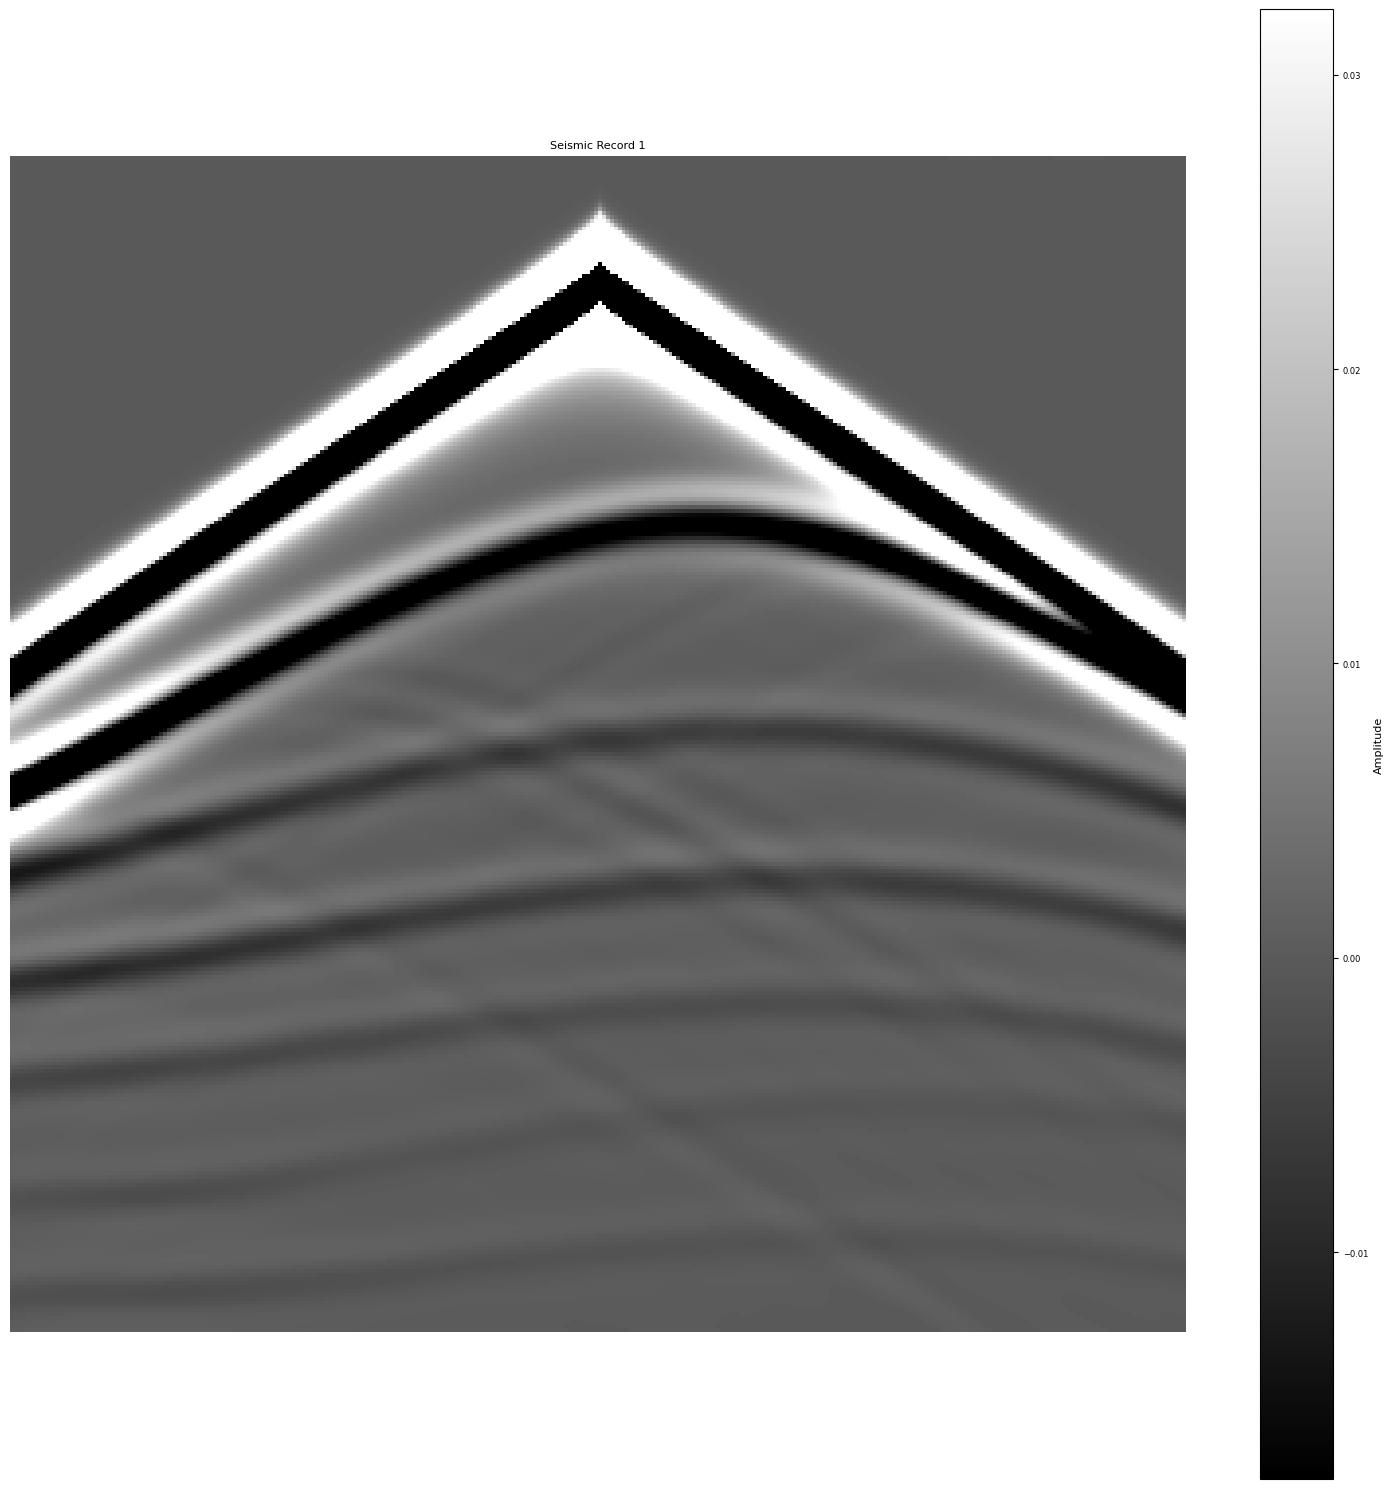

In [ ]:
#@title classic 2D visulization
def visualize_data(data, mode='velocity', n_samples=None, figsize=(15, 15), save_path=None):
    """
    统一的可视化函数，可以绘制速度模型或地震记录

    参数:
        data: torch.Tensor, 输入数据
            - 速度模型模式: shape为(batch, channel, height, width)
            - 地震记录模式: shape为(batch, time, receivers)
        mode: str, 可选 'velocity' 或 'seismic'
        n_samples: int, 可选，显示多少个样本
        figsize: tuple, 图像大小
        save_path: str, 可选，保存图像的路径
    """
    plt.figure(figsize=figsize)
    data = data.detach().cpu()

    # 设置要显示的样本数
    if n_samples is None:
        n_samples = len(data)
    n_samples = min(n_samples, len(data))

    # 计算子图布局
    n_rows = int(np.sqrt(n_samples))
    n_cols = int(np.ceil(n_samples / n_rows))

    for i in range(n_samples):
        plt.subplot(n_rows, n_cols, i + 1)

        if mode.lower() == 'velocity':
            # 速度模型可视化
            field = data[i][0].numpy()  # 取第一个通道
            im = plt.imshow(field, cmap='viridis')
            cbar = plt.colorbar(im)
            cbar.set_label('Velocity (m/s)', fontsize=8)  # 减小colorbar标签字体
            cbar.ax.tick_params(labelsize=6)  # 减小colorbar刻度字体
            plt.title(f'Velocity Model {i+1}', fontsize=8)  # 减小标题字体

        elif mode.lower() == 'seismic':
            # 地震记录可视化
            field = data[i]
            # 使用分位数计算每个记录的颜色范围
            vmin, vmax = torch.quantile(field, torch.tensor([0.05, 0.95]))
            im = plt.imshow(field.T,
                          cmap='gray',
                          vmin=vmin,
                          vmax=vmax)
            cbar = plt.colorbar(im)
            cbar.set_label('Amplitude', fontsize=8)  # 减小colorbar标签字体
            cbar.ax.tick_params(labelsize=6)  # 减小colorbar刻度字体
            plt.title(f'Seismic Record {i+1}', fontsize=8)  # 减小标题字体

        else:
            raise ValueError("mode must be either 'velocity' or 'seismic'")

        plt.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

visualize_data(seismic_records[None,...,0,1].detach().cpu(),'seismic',save_path=f_path+"seismic_model_visualization_seed0_slice_0_1.pdf") # [H,nt,dim,X/Y value]

In [ ]:
#@title synthetic seismic dataset

import torch
import deepwave
from tqdm import tqdm
import numpy as np

# M1: direct local storage, 2.16TB sized.
def create_dataset(num_samples=10000, dim=128, device='cuda'):
    """
    Create a dataset of seismic records

    Args:
        num_samples: Number of samples in the dataset (default: 10000)
        dim: Dimension of velocity model (default: 128)
        device: Computation device (default: 'cuda')

    Returns:
        torch.Tensor: Dataset of seismic records (num_samples, 300, 300, 300, 2)
    """
    dataset = []

    # Use tqdm to show progress bar
    for i in tqdm(range(num_samples), desc="Generating dataset"):
        # Create a random velocity model for each sample
        v = create_velocity_model(cfg, device)  # [128, 128, 128]

        # Generate seismic records for this velocity model
        seismic_record = generate_3d_seismic_records(v, dim, device).permute(1, 2, 0, 3)  # [300, 300, 300, 2]

        # Append to dataset
        dataset.append(seismic_record.cpu())  # Move to CPU to save GPU memory

        # Optionally save intermediate results to prevent data loss
        if (i + 1) % 100 == 0:
            torch.save(torch.stack(dataset), f'dataset_partial_{i+1}.pt')

    # Stack all samples into a single tensor
    dataset = torch.stack(dataset)  # [num_samples, 300, 300, 300, 2]

    return dataset

# Generate the dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = create_dataset(num_samples=10000, dim=300, device=device)

# Save the complete dataset
torch.save(dataset, 'seismic_dataset_10000.pt')
print(f"Dataset shape: {dataset.shape}")  # [10000, 300, 300, 300, 2]


# M2: 使用数据生成器而非存储完整数据集
class SeismicDataGenerator:
    def __init__(self, cfg, dim=300, device='cuda'):
        self.cfg = cfg
        self.dim = dim
        self.device = device

    def __call__(self, batch_size=32):
        """Generate a batch of seismic records on-the-fly"""
        batch = []
        for _ in range(batch_size):
            v = create_velocity_model(self.cfg, self.device)
            seismic_record = generate_3d_seismic_records(v, self.dim, self.device).permute(1, 2, 0, 3)
            batch.append(seismic_record)
        return torch.stack(batch)


<ipython-input-9-c6ce3575923a>:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


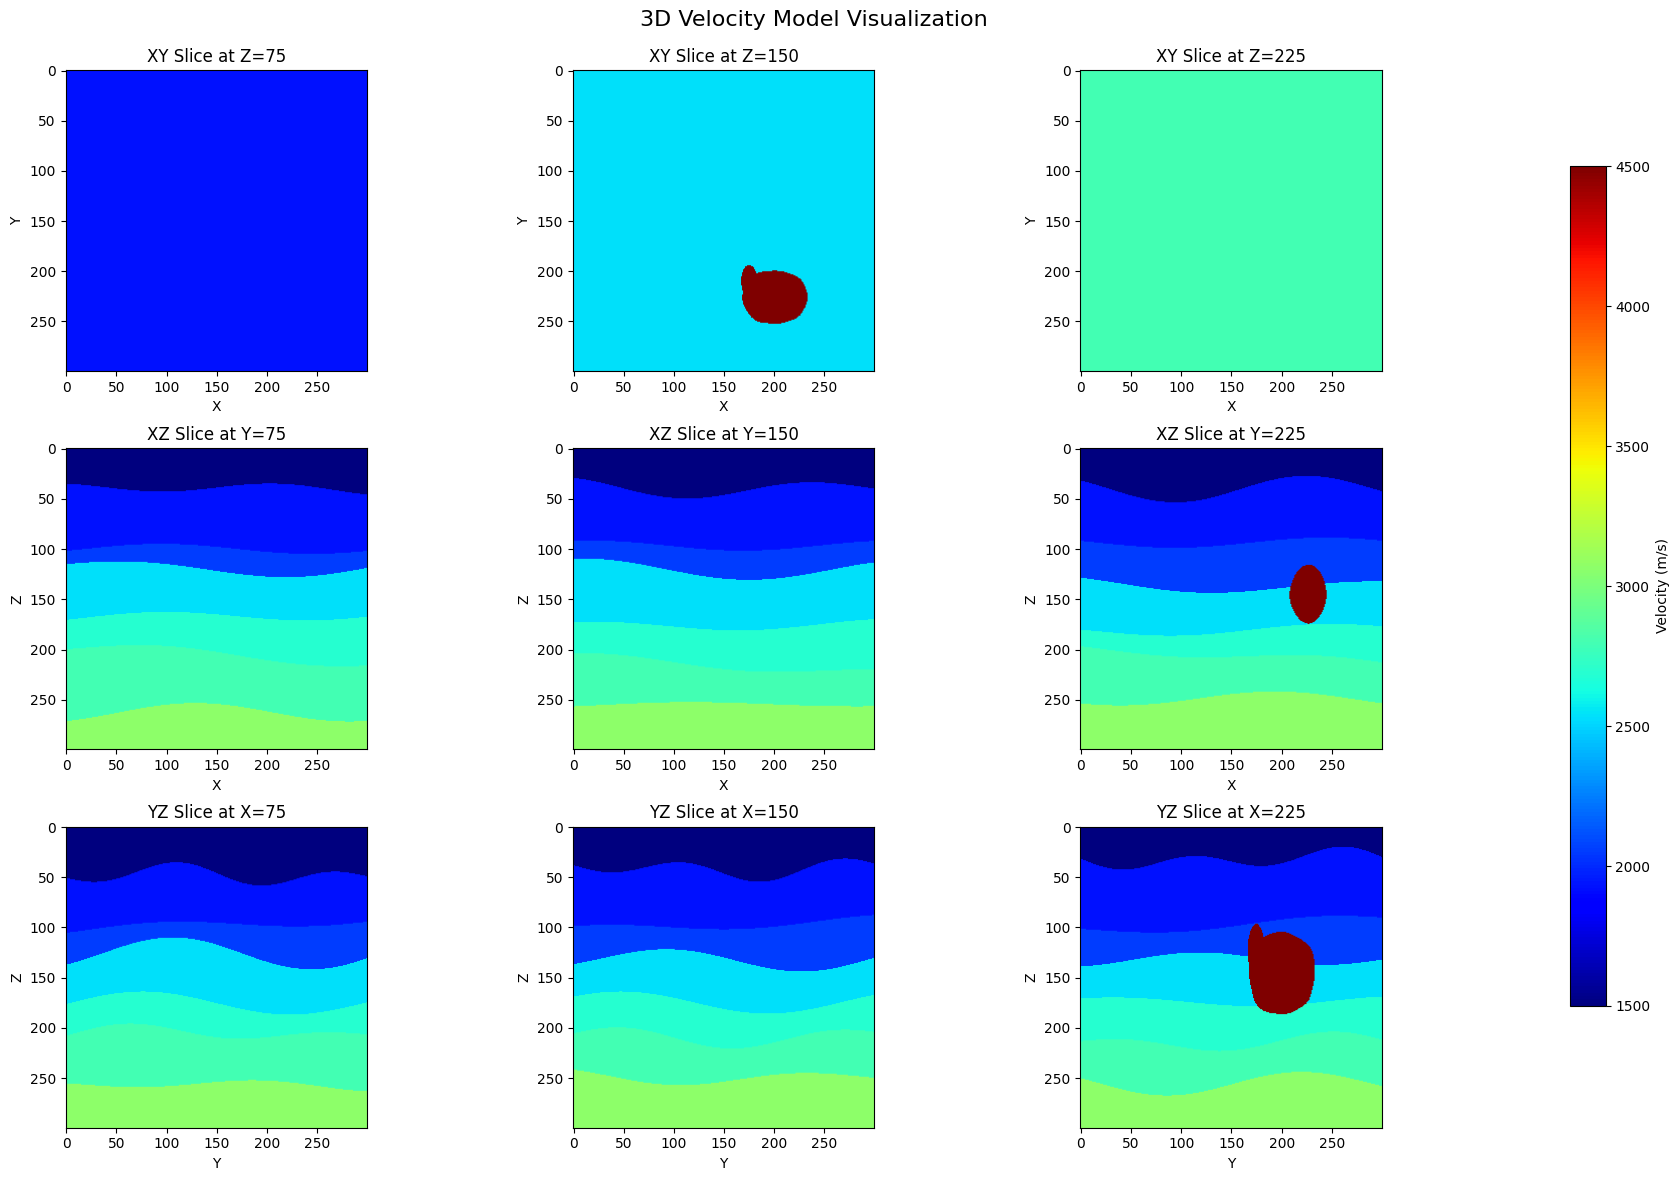

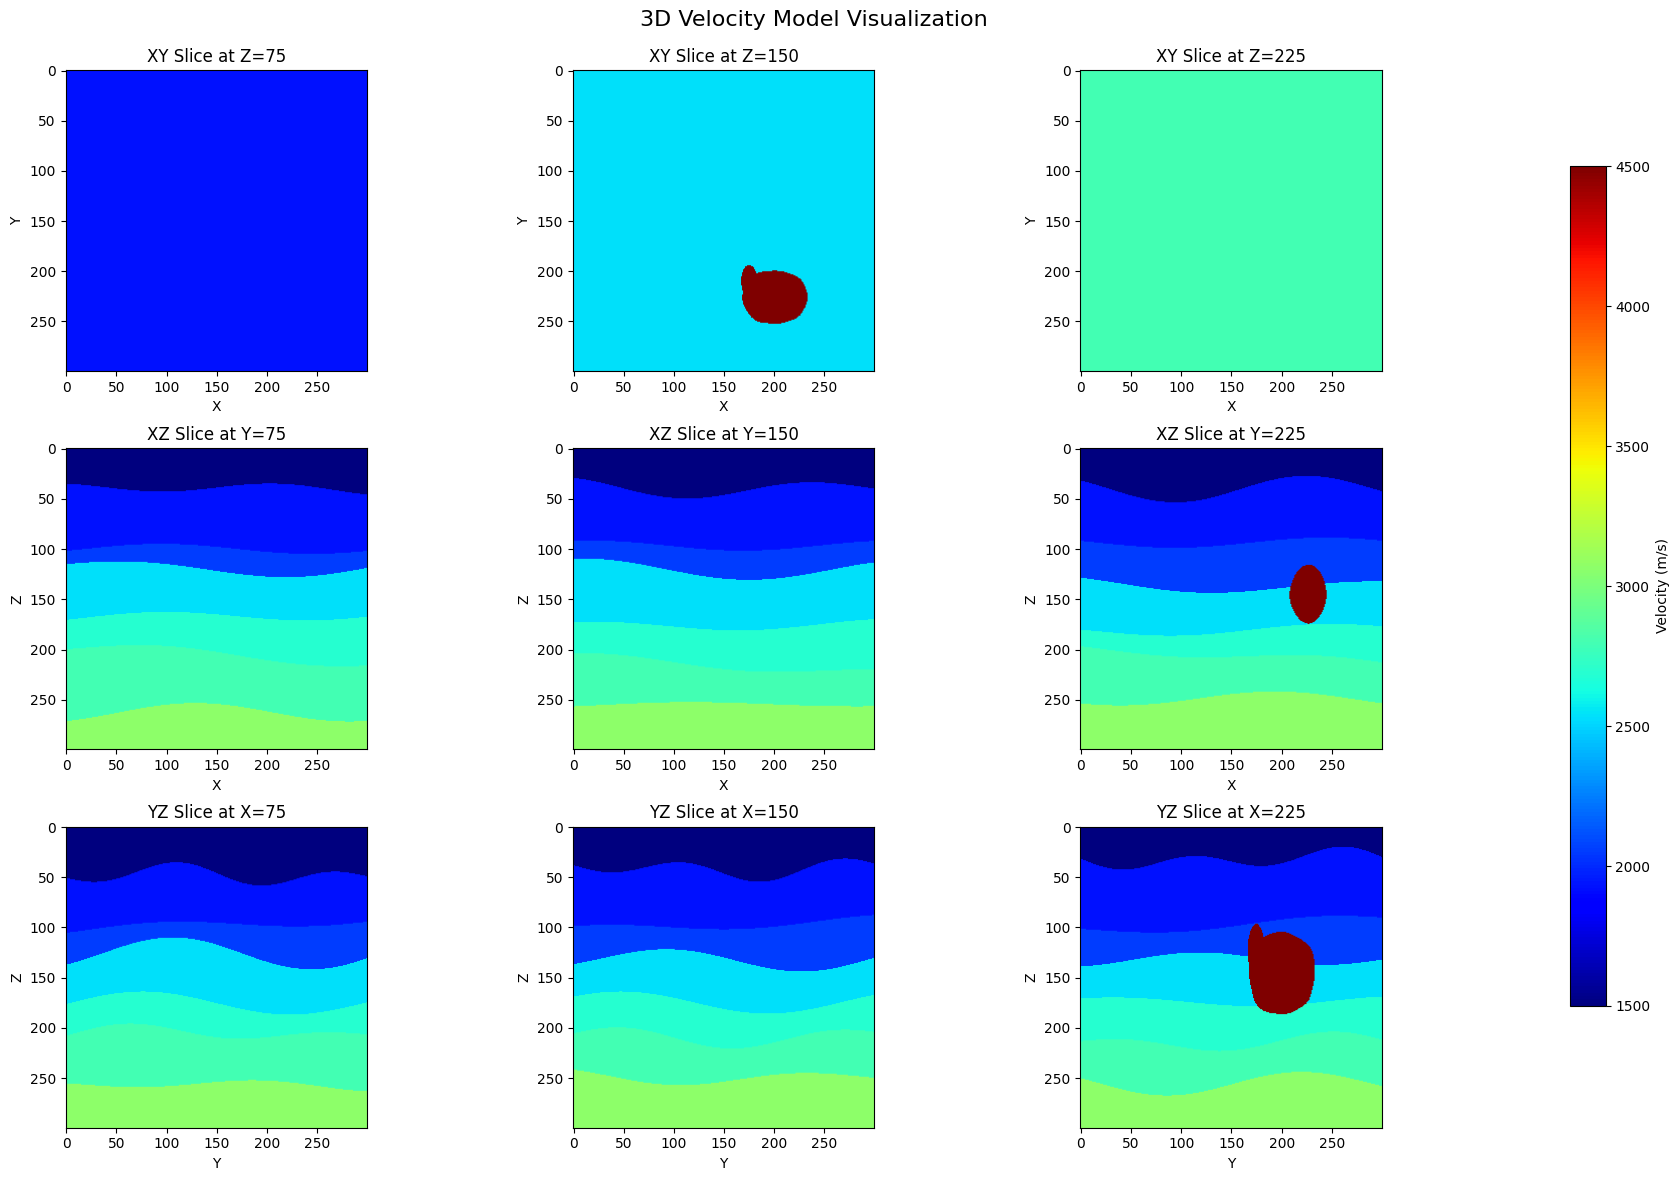

In [ ]:
#@title 3D velocity model visulization
import matplotlib.pyplot as plt
import numpy as np
def visualize_velocity_model_comprehensive(velocity_model):
    """Comprehensive visualization of 3D velocity model with multiple views"""
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import Normalize

    # Convert to numpy
    vel = velocity_model.cpu().numpy()
    nx, ny, nz = vel.shape

    # Create figure
    fig = plt.figure(figsize=(18, 12))

    # Define colormap and normalization
    cmap = plt.cm.jet
    norm = Normalize(vmin=vel.min(), vmax=vel.max())

    # 1. XY slices at different depths
    depths = [nz//4, nz//2, 3*nz//4]
    for i, depth in enumerate(depths):
        ax = fig.add_subplot(3, 3, i+1)
        im = ax.imshow(vel[:, :, depth], cmap=cmap, norm=norm)
        ax.set_title(f'XY Slice at Z={depth}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # 2. XZ slices at different Y positions
    y_positions = [ny//4, ny//2, 3*ny//4]
    for i, y_pos in enumerate(y_positions):
        ax = fig.add_subplot(3, 3, i+4)
        im = ax.imshow(vel[:, y_pos, :].T, cmap=cmap, norm=norm)
        ax.set_title(f'XZ Slice at Y={y_pos}')
        ax.set_xlabel('X')
        ax.set_ylabel('Z')

    # 3. YZ slices at different X positions
    x_positions = [nx//4, nx//2, 3*nx//4]
    for i, x_pos in enumerate(x_positions):
        ax = fig.add_subplot(3, 3, i+7)
        im = ax.imshow(vel[x_pos, :, :].T, cmap=cmap, norm=norm)
        ax.set_title(f'YZ Slice at X={x_pos}')
        ax.set_xlabel('Y')
        ax.set_ylabel('Z')

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Velocity (m/s)')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.suptitle('3D Velocity Model Visualization', fontsize=16)
    plt.subplots_adjust(top=0.93)

    plt.show()

    return fig
# Visualize the model
visualize_velocity_model_comprehensive(batch_velocity_models[0,...,4])



In [ ]:
#@title interactive 3D visulization

def visualize_velocity_isosurfaces(velocity_model):
    """Create interactive 3D visualization using isosurfaces"""
    import plotly.graph_objects as go
    import numpy as np

    # Convert to numpy
    vel = velocity_model.cpu().numpy()
    nx, ny, nz = vel.shape

    # Create a figure
    fig = go.Figure()

    # Calculate values for isosurfaces
    v_min = vel.min()
    v_max = vel.max()
    values = np.linspace(v_min + 0.2*(v_max-v_min), v_max - 0.2*(v_max-v_min), 3)

    # Add isosurfaces
    for i, value in enumerate(values):
        opacity = 0.3 if i == 1 else 0.2

        fig.add_trace(go.Isosurface(
            x=np.arange(nx).reshape(nx, 1, 1).repeat(ny, axis=1).repeat(nz, axis=2).flatten(),
            y=np.arange(ny).reshape(1, ny, 1).repeat(nx, axis=0).repeat(nz, axis=2).flatten(),
            z=np.arange(nz).reshape(1, 1, nz).repeat(nx, axis=0).repeat(ny, axis=1).flatten(),
            value=vel.flatten(),
            isomin=value,
            isomax=value,
            opacity=opacity,
            surface_count=1,
            colorscale='Jet',
            caps=dict(x={'show': False}, y={'show': False}, z={'show': False})
        ))

    # Add slices
    mid_x, mid_y, mid_z = nx//2, ny//2, nz//2

    # X slice
    fig.add_trace(go.Volume(
        x=np.ones(ny*nz)*mid_x,
        y=np.arange(ny).reshape(ny, 1).repeat(nz, axis=1).flatten(),
        z=np.arange(nz).reshape(1, nz).repeat(ny, axis=0).flatten(),
        value=vel[mid_x, :, :].flatten(),
        opacity=0.8,
        surface_count=1,
        colorscale='Jet'
    ))

    # Update layout
    fig.update_layout(
        title='Velocity Model - Isosurfaces and Slices',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        width=800,
        height=800
    )

    fig.show()
    return fig


# Install plotly if not already installed
# !pip install plotly

# Visualize the model
visualize_velocity_isosurfaces(velocity_model)


Output hidden; open in https://colab.research.google.com to view.